In [1]:
import numpy as np
import time
from PIL import Image

In [2]:
def clear(screen, color=[0, 0, 0]):
    # Assign color to all pixels
    screen[:] = np.array(color, dtype=np.uint8)    
    return screen

In [3]:
def bounding_box(points, screen):
    bbmin = np.floor(np.min(points, 0)).astype('int')
    bbmax = np.ceil(np.max(points, 0)).astype('int')
    bbmin = np.clip(bbmin, [0, 0], [screen.shape[0] - 1, screen.shape[1] - 1])
    bbmax = np.clip(bbmax, [0, 0], [screen.shape[0] - 1, screen.shape[1] - 1])    
    return bbmin, bbmax

In [4]:
def backfacing(t_points):
    # Check derminant (aka 2d cross product) of a triangle sector
    M = np.concatenate(([t_points[1] - t_points[0]], [t_points[2] - t_points[0]]))
    return np.linalg.det(M) < 0

In [5]:
def point_in_triangle(p, t_points):
    for i in range(3):
        # Compute inward-pointing 2d normal of edge
        edge = t_points[(i + 1) % 3] - t_points[i]
        n = np.array([-edge[1], edge[0]])
        
        # The point is inside iff it lies on the correct side of all edges
        if np.dot(n, p - t_points[i]) < 0:
            return False
        
    return True

In [6]:
def vertex_shader(V):
    # Cut off z component
    # TODO: those are not NDC yet
    return V[:, 0:2]

In [7]:
def rasterize(V, T, screen):
    # Pineda algorithm
    fragments = []
    
    for t in T:
        # V[t] is the 2x3 matrix of triangle vertex positions
        if backfacing(V[t]):
            continue
        
        # Compute bounding box
        bbmin, bbmax = bounding_box(V[t], screen)
        
        # Check fragments within bounding box
        for x in range(bbmin[0], bbmax[0] + 1):
            for y in range(bbmin[1], bbmax[1] + 1):
                if point_in_triangle([x, y], V[t]):
                    fragments.append([x, y])
    
    return fragments

In [8]:
def fragment_shader(fragments, sceen):
    for x, y in fragments:
        screen[x, y] = [255, 255, 0]

In [9]:
def render(V, T, screen):
    screen = clear(screen, [64, 64, 64])
    
    # Transform vertices into normalized device coordinates (ndc)
    V_ndc = vertex_shader(V)

    # TODO: viewport transform?
    
    # Generate list of fragments
    fragments = rasterize(V_ndc, T, screen)
    
    # Compute pixel colors
    screen = fragment_shader(fragments, screen)

Render took 0.096167 seconds.


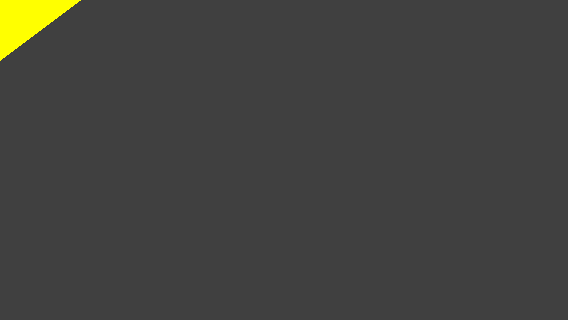

In [10]:
height = 320
width = height * 16 // 9

# Load mesh
V = np.array([[0, 0, 0], [80, 0, 0], [0, 60, 0]], dtype=np.float)
T = np.array([[0, 1, 2]], dtype=np.int)

# Init screen buffer
screen = np.zeros((width, height, 3), dtype=np.uint8)

start = time.time()

render(V, T, screen)

seconds = time.time() - start
print("Render took %f seconds." % seconds)

# Show screen buffer
Image.fromarray(np.transpose(screen, (1, 0, 2)))